In [36]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [37]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [38]:
%matplotlib inline

In [39]:
transform = transforms.Compose([transforms.Resize((84, 84)),
                                transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='cifar_data', train=True, transform=transform, download=True)
valid_dataset = datasets.CIFAR10(root='cifar_data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [40]:
def ninblock(in_channels, out_channels):
  block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1),
      nn.ReLU(),
      nn.BatchNorm2d(out_channels)
  )
  return block

In [46]:
class NIN(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
        ninblock(96, 96),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
        ninblock(256, 256),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
        ninblock(384, 384),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(),
        nn.Conv2d(in_channels=384, out_channels=10, kernel_size=3, padding=1),
        ninblock(10, 10)
    )
  
  def forward(self, X):
    X = self.feature_extractor(X)
    logits = torch.flatten(X, 1)
    probs = F.softmax(logits, 1)
    return logits, probs

![NIN Architecture](NIN_architecture.png "NIN")

In [42]:
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for X, y in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for X, y in valid_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device):
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  for epoch in range(0, epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    train_acc = get_accuracy(model, train_loader, device)
    valid_acc = get_accuracy(model, valid_loader, device)

    print(f'{datetime.now().time().replace(microsecond=0)} ---- '
          f'Epoch: {epoch}\t'
          f'Train Loss: {train_loss:.4f}\t'
          f'Valid Loss: {valid_loss:.4f}\t'
          f'Train Accuracy: {100 * train_acc:.2f}\t'
          f'Valid Accuracy: {100 * valid_acc:.2f}')
      
  plot_losses(train_losses, valid_losses)
  return model, optimizer, (train_losses, valid_losses)


def get_accuracy(model, data_loader, device):
  correct_pred = 0
  n = 0
  with torch.no_grad():
    model.eval()
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)
      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y.size(0)
      correct_pred += (y == predicted_labels).sum()

    return correct_pred.float()/n

def plot_losses(train_losses, valid_losses):
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig,ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training loss')
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.set(title='Loss over epochs',  xlabel='Epoch', ylabel='loss')
  ax.legend()
  fig.show()

  plt.style.use('default')

02:50:07 ---- Epoch: 0	Train Loss: 2.1763	Valid Loss: 2.0180	Train Accuracy: 21.36	Valid Accuracy: 21.13
02:50:44 ---- Epoch: 1	Train Loss: 1.9043	Valid Loss: 4.0022	Train Accuracy: 28.02	Valid Accuracy: 28.16
02:51:21 ---- Epoch: 2	Train Loss: 1.6893	Valid Loss: 1.6905	Train Accuracy: 36.45	Valid Accuracy: 36.31
02:51:58 ---- Epoch: 3	Train Loss: 1.5567	Valid Loss: 2.7815	Train Accuracy: 41.12	Valid Accuracy: 40.62
02:52:35 ---- Epoch: 4	Train Loss: 1.4408	Valid Loss: 1.5692	Train Accuracy: 41.77	Valid Accuracy: 40.97
02:53:13 ---- Epoch: 5	Train Loss: 1.3509	Valid Loss: 3.0380	Train Accuracy: 47.69	Valid Accuracy: 46.40
02:53:50 ---- Epoch: 6	Train Loss: 1.2855	Valid Loss: 1.2911	Train Accuracy: 52.86	Valid Accuracy: 51.37
02:54:28 ---- Epoch: 7	Train Loss: 1.2266	Valid Loss: 1.2278	Train Accuracy: 58.24	Valid Accuracy: 55.96
02:55:05 ---- Epoch: 8	Train Loss: 1.1669	Valid Loss: 21.8762	Train Accuracy: 57.11	Valid Accuracy: 54.59
02:55:42 ---- Epoch: 9	Train Loss: 1.1117	Valid Loss: 

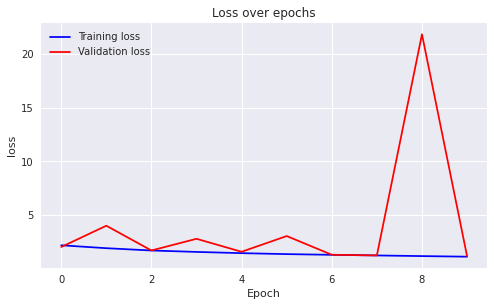

In [47]:
model = NIN()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, 10, DEVICE)

In [33]:
model = NIN()

In [34]:
print(model)

NIN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): Sequential(
      (0): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): Sequential(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sequential(
 